# Assignment 3 - Monte Carlo Methods


Before you start with this problem:
- Study the corresponding slide deck(s) and consider re-watching the lecture recording(s).
- Internalize the material until you feel confident you can work with them or implement them yourself. Only then start working on this assignment; otherwise, you will waste a lot of time.

---

<div class="alert alert-warning">

**Due-Date:** see Moodle
   
**Constraints**: Operations on SciPy and NumPy arrays only.
  
**Automatic Grading:** 

- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.
- make sure to remove all `raise NotImplementedError()` statements
- Put results in the corresponding variable; otherwise, we will not grade your solution (i.e., we assign 0 points).
- Do not delete cells.
    
**Submission:** Submit the notebook via Moodle.
- naming convention: `k<8 digits of student ID>.ipynb`
- correct naming for student with id k01234567: k01234567.ipynb
- some examples of incorrectly named submissions:
    - k1234567.ipynb (7 digits)
    - k01234567.pdf (converted to pdf)
    - k01234567.html (converted to html)
    - 01234567.ipynb (k is missing)
    - k01324567.ipynb (incorrect student ID)
    -  ...
- notbooks that cannot be assign automatically will not be graded
    
**Questions?** Post it into the forum!
</div>

## Running code cells

To execute a code cell, use either `Ctrl-Enter`, `Shift-Enter`, or the GUI buttons above.
    
<div class="alert alert-info">

In the third assignment, you will implement algorithms that were presented in the lectures on Monte Carlo methods. You can gain 15 points in total. Please make sure that you do not overlook any of the questions.

<br>

For this assignment we will use Gymnasium (https://gymnasium.farama.org), the Black Jack environment and the `Fishlake` environment. Please make sure you are using the `fishlake.py` that is distributed along with the current assignment.

<br>

To solve this exercise, read the notebook carefully from beginning to end and fill out coding parts and answer questions marked with **TODO**.

<br>

There are a total of 26 points in this assignment. To make sure you do not forget any **TODO**s in this rather long notebook, here is a list:

- Implement Episode Generation (2 Points)
- Implement MC Policy Evaluation (12 Points)
    - First-visit MC Evaluation (6 points)
    - Every-visit MC Evaluation (6 points)
- Implement MC On-Policy Control (6 Points)
- Analysis of MC on Fishlake (6 Points)
    - MC vs. DP (2 points)
    - True/False questions (4 points) 

**Do not forget to reset the kernel, and run all the code cells, before saving and submitting the assignment!**
</div>

Some# Blackjack - A Model-free Environment, Monte Carlo Methods

Let us now try Monte Carlo methods on a model-free environment (where it is very hard / impossible to use Dynamic Programming). We will use the game of Black Jack, as presented in the lecture. In general, MC methods are model free, but you might have used some convenience functions

<div class="alert alert-info">

The following description is adapted from the environment description at https://gymnasium.farama.org/environments/toy_text/blackjack/:

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over. They're playing against dealer
    that follows a fixed strategy.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    
    This game is played with an infinite deck (drawing with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.
    
    If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    
    The reward for winning is +1, drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of:
    
    the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    
</div>

### Preliminaries

What follows are the imports, the instantiation of the BlackJack gym-environment, and the introduction of some helper functions. You will have to run these cells first, before starting to implement and run your algorithms.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import fishlake
import blackjack_convenience as blackjack
import testing

from collections import defaultdict

from typing import List, Tuple, Dict, Callable

np.set_printoptions(precision=4, suppress=True, threshold=200)

### Let's play some BlackJack...

In [27]:
# the BlackJack environment does **not** give access to the dynamics or the size of the state space
# so there is no (easy) way we can use dynamic programming here, we are forced to use model-free methods
# the BlackJack environment has no 'render()' function either --- printing the state encoding is enough.
# The option `sab=True` follows the simplified Blackjack rules as described in the textbook by Sutton and Barto.
blackjack_env = gym.make("Blackjack-v1", sab=True)

# we can query the size of the action space:
print("Size of the action space:", blackjack_env.action_space.n)

# we can (indirectly) query the size of the observation space:
print("Structure/sizes of the observation space:", blackjack_env.observation_space)

# we can seed the PRNG of the environment for:
# - reproducibility
# - easier debugging
# the PRNG is used by the environment to determine the order of the cards
# to reset the environment into its inital state, we can call 'reset()'
state, _ = blackjack_env.reset(seed=1234)

# let's look at the components of the state encoding of the initial state
print(state)

Size of the action space: 2
Structure/sizes of the observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
(15, 10, 0)


### The state encoding desugars into this ...

In [28]:
(player_score, dealer_score, usable_ace) = state

# We define a type annotation for states to give you a hint in the methods below
# whenever a function is expected to receive/output these states
BlackJackState = Tuple[int, int, int]

 ... but this is not really important for us!
Because the state is already a tuple, we will just use this tuple as a key into several dictionaries. They will store various value function approximations, policies, as well as support data.

## Defining Default BlackJack Policies

What follows are functions that generate basic policies.

In [29]:
# Just as we did for BlackJack states, instead of having to write Dict[BlackJackState, np.ndarray]
# every time, we define a type annotation for policies. These policies will be
# dictionaries that use BlackJackStates as keys and the values are np.ndarrays
BlackJackPolicy = Dict[BlackJackState, np.ndarray]


# we include here the example policy that was also used in class:
def create_example_policy() -> BlackJackPolicy:
    """
    Create a policy that sticks if the player score is >= 20 and hits otherwise.
    """
    policy = dict()
    for score in range(4, 22):  # 4 - 21
        for dealer_score in range(1, 11):  # 1 - 10
            for useable_ace in [1, 0]:
                observation = (score, dealer_score, useable_ace)
                if score >= 20:
                    # stick
                    policy[observation] = np.array([1.0, 0.0])
                else:
                    # hit
                    policy[observation] = np.array([0.0, 1.0])
    return policy


# and the random policy that chooses an action with equal probability
def create_random_policy() -> BlackJackPolicy:
    """
    Create the random policy.
    """
    policy = dict()

    for score in range(4, 22):
        for dealer_score in range(1, 11):
            for useable_ace in [1, 0]:
                observation = (score, dealer_score, useable_ace)
                policy[observation] = np.array([0.5, 0.5])
    return policy

---
## (1) Episode Generation (2 Points)
Here, you will define a helper function that will generate an episode, given an environment and a policy.

In [30]:
def generate_episode(
    rng: np.random._generator.Generator,
    env: gym.Env,
    policy: BlackJackPolicy,
    seed: int = 1234,
) -> List[Tuple[BlackJackState, int, float]]:
    """Helper function to generate an episode given an environment and a policy.

    Args:
        rng: random number generator
        env: the gym environment
        policy: the policy to follow during the episode
        seed: seed for the random number generator

    Returns:
        episode: The sequence of states, actions and rewards in the episode.
    """
    # implement a helper function to generate an episode, given an environment and a policy
    # an episode is a list of (state, action, reward) tuples:
    # episode = [
    #    (state_1, action_1, reward_2),
    #    (state_2, action_2, reward_3),
    #    ...
    #    (state_T-1, action_T-1, reward_T)
    # ]
    state, _ = env.reset(seed=int(seed))
    actions = np.arange(env.action_space.n, dtype=int)
    episode = []
    done = False
    # while not done:
    #     action = rng.choice(actions, p=policy[state])
    # TODO

    # YOUR CODE HERE
    while not done:
        # Select action according to policy probabilities for current state
        action = rng.choice(actions, p=policy[state])
        
        # Take action in environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Store (state, action, reward) tuple
        episode.append((state, action, reward))
        
        # Update for next iteration
        state = next_state
        done = terminated or truncated
        
    return episode


# For typing convenience, we can define the "typing hint"
#  for this function
EpisodeGenerator = Callable[
    [
        np.random._generator.Generator,
        gym.Env,
        BlackJackPolicy,
        int,
    ],
    List[Tuple[BlackJackState, int, float]],
]

In [31]:
rng = np.random.default_rng(1245)
random_policy = create_random_policy()
episode = generate_episode(
    rng=rng,
    env=blackjack_env,
    policy=random_policy,
    seed=4321,
)
print(episode)

assert len(episode) > 0, "Your implementation of generates empty episodes"
for s, a, r in episode:
    assert testing.is_type(s, tuple)
    assert testing.is_type(s[0], [int, np.int64])
    assert testing.is_type(s[1], [int, np.int64])
    assert testing.is_type(s[2], int)
    assert testing.is_type(a, [int, np.int64])
    assert testing.is_type(r, [float, int, np.int64])

    print(s, a, r)



[((17, 10, 0), 1, 0.0), ((21, 10, 0), 1, -1.0)]
(17, 10, 0) 1 0.0
(21, 10, 0) 1 -1.0


## (2) Monte Carlo Evaluation (12 Points)
Ler's get started: implement the first-visit and every-visit MC policy evaluation algorithms and compare them.

### (2.1) First-Visit MC Policy Evaluation (6 points)

Let's start with the first-visit MC policy evaluation algorithm.

In [32]:
def mc_first_visit_policy_evaluation(
    rng: np.random._generator.Generator,
    env: gym.Env,
    policy: BlackJackPolicy,
    generate_episode_func: EpisodeGenerator,
    n_episodes: int,
    gamma: float = 1.0,
    n_print_every: int = 10**4,
    seed: int = 1234,
) -> Dict[BlackJackState, float]:
    """
    Monte Carlo prediction algorithm, which calculates the value function
    for a given policy

    Args:
        rng: random number generator
        env: the gym environment
        policy: the policy to be evaluated
        generate_episode_func: the method for generating episodes.
        n_episodes: number of episodes to sample
        gamma: the discount factor
        n_print_every: print a message after this many episodes
        seed: seed for the random number generator.

    Returns:
        the value function associated with 'policy'
    """
    # a note on the value function estimate 'V', 'G_sum' and 'G_count':
    # those functions must be stored as a 'dict' or 'defaultdict', where
    #
    # 'key' is a tuple encoding the state (player_sum, dealer_sum, useable_ace)
    #
    # and
    #
    # 'value' is the value of this state
    #
    # print(V) should yield something similar to this (except for the actual numerical values):
    #
    #     defaultdict(float,
    #             {(21, 10, 1): 0.8863134657836644,
    #              (7, 10, 0): -0.563816604708798,
    #              (11, 10, 0): -0.10879368658399098,
    #              (20, 10, 0): 0.43548387096774194,
    #              (13, 7, 1): -0.3431372549019608,
    #              (12, 7, 0): -0.5573080967402734,
    #              (21, 7, 0): 0.9257294429708223,
    #              (13, 6, 0): -0.5404255319148936,
    #              (19, 6, 0): -0.6908077994428969,
    #              ...})
    #
    # please make sure you use this format, as only then the very convenient plotting function will work
    #
    # for more info checkout the documentation on 'defaultdict':
    # https://docs.python.org/3/library/collections.html?highlight=defaultdict#collections.defaultdict
    #
    # if this is too much voodoo for you, you can use 'dict', but you have to do extra steps there
    # in case a key does not exist in the dictionary yet!
    G_sum = defaultdict(lambda: 0.0)
    G_count = defaultdict(lambda: 0.0)

    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        episode = generate_episode_func(
            rng=rng,
            env=env,
            policy=policy,
            seed=int(seed + i_episode),
        )

        # TODO: compute return G, update G_sum, G_count
        # YOUR CODE HERE
        # Get states from episode
        states_in_episode = [s for s, _, _ in episode]
        
        # Calculate returns for each step
        G = 0.0
        # Process episode backwards
        for t in range(len(episode)-1, -1, -1):
            state, _, reward = episode[t]
            
            # Calculate return (discounted sum of rewards from time t)
            G = gamma * G + reward
            
            # If this is the first visit to the state
            if state not in states_in_episode[:t]:
                G_sum[state] += G
                G_count[state] += 1.0


    V = defaultdict(lambda: 0.0)
    # TODO: compute the value function estimate 'V' from 'G_sum' and 'G_count'
    # YOUR CODE HERE
    for state in G_sum.keys():
        if G_count[state] > 0:
            V[state] = G_sum[state] / G_count[state]

    return V

### (2.2) Every-Visit MC Policy Evaluation (6 points)

In [33]:
def mc_every_visit_policy_evaluation(
    rng: np.random._generator.Generator,
    env: gym.Env,
    policy: BlackJackPolicy,
    generate_episode_func: EpisodeGenerator,
    n_episodes: int,
    gamma: float = 1.0,
    n_print_every: int = 10**4,
    seed: int = 1234,
) -> Dict[BlackJackState, float]:
    """
    Monte Carlo prediction algorithm, which calculates the value function
    for a given policy, aggregating the returns for a state at every visit in
    every episode.

    Args:
        rng: random number generator
        env: the gym environment
        policy: the policy to be evaluated
        generate_episode_func: the method for generating episodes.
        n_episodes: number of episodes to sample
        gamma: the discount factor
        n_print_every: print a message after this many episodes
        seed: seed for the random number generator.
    Returns:
        the value function associated with 'policy'
    """
    G_sum = defaultdict(lambda: 0.0)
    G_count = defaultdict(lambda: 0.0)

    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        episode = generate_episode_func(
            rng=rng,
            env=env,
            policy=policy,
            seed=int(seed + i_episode),
        )

        # TODO: compute return G, update G_sum, G_count
        # YOUR CODE HERE
        # Calculate returns for each step
        G = 0.0
        # Process episode backwards
        for t in range(len(episode)-1, -1, -1):
            state, _, reward = episode[t]
            
            # Calculate return (discounted sum of rewards from time t)
            G = gamma * G + reward
            
            # Update returns for every visit
            G_sum[state] += G
            G_count[state] += 1.0

    V = defaultdict(lambda: 0.0)
    # TODO: compute the value function estimate 'V' from 'G_sum' and 'G_count'
    # YOUR CODE HERE
    for state in G_sum.keys():
        if G_count[state] > 0:
            V[state] = G_sum[state] / G_count[state]

    return V

### Run MC Policy Evaluation for Black Jack
Okay, let's now run the implemented algorithms on the Black Jack environment. You already know from the lecture slides what the outputs.

**First-visit MC Policy Evaluation**

In [34]:
# let's create the example policy
example_policy = create_example_policy()

# TODO: for debugging, it might be a good idea to set this to a smaller value -> only temporarily though!
# set it back to (5 * 10 ** 4) before you re-run and submit your notebook!
n_episodes = 5 * 10**4

seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
fv_policy_value = mc_first_visit_policy_evaluation(
    rng,
    blackjack_env,
    example_policy,
    generate_episode_func=generate_episode,
    n_episodes=n_episodes,
)

assert len(fv_policy_value) > 0, "Your implementation generates an empty value function"
for state, val in fv_policy_value.items():
    assert testing.is_type(state, tuple)
    assert testing.is_type(state[0], [int, np.int64])
    assert testing.is_type(state[1], [int, np.int64])
    assert testing.is_type(state[2], int)
    assert testing.is_type(val, [float, int])



Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.


<Figure size 640x480 with 0 Axes>

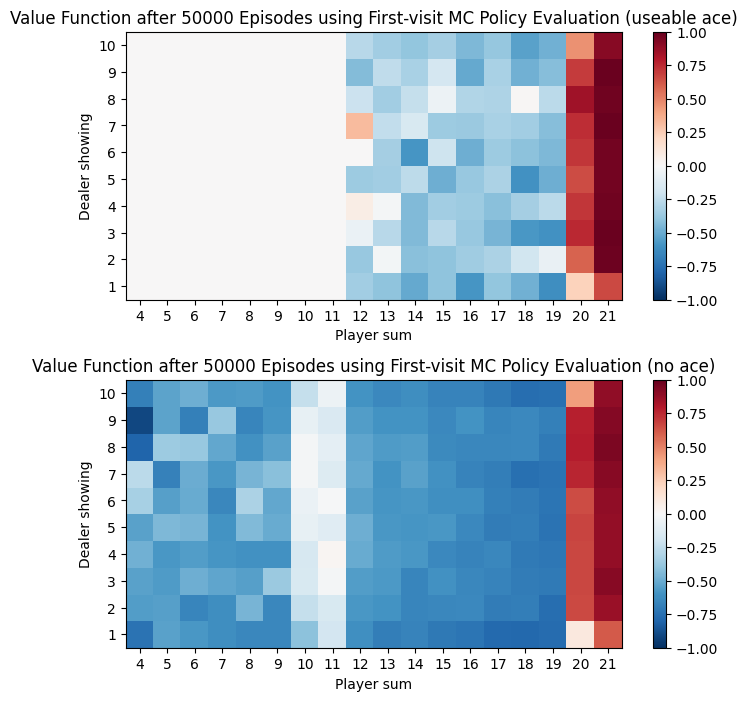

In [35]:
blackjack.plot_value_function(
    fv_policy_value,
    title=f"Value Function after {n_episodes} Episodes using First-visit MC Policy Evaluation",
)

**Every visit Policy Estimation**

Now let's run exactly the same tests for the every-visit MC policy estimation algorithm.

In [36]:
# let's create the example policy (the same policy as above)
example_policy = create_example_policy()

# TODO: for debugging, it might be a good idea to set this to a smaller value -> only temporarily though!
# set it back to (5 * 10 ** 4) before you re-run and submit your notebook!
n_episodes = 5 * 10**4

# DO NOT CHANGE THE RANDOM NUMBER GENERATORS!
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
ev_policy_value = mc_every_visit_policy_evaluation(
    rng,
    blackjack_env,
    example_policy,
    n_episodes=n_episodes,
    generate_episode_func=generate_episode,
    seed=1234,
)

assert len(ev_policy_value) > 0, "Your implementation generates an empty value function"
for state, val in ev_policy_value.items():
    assert testing.is_type(state, tuple)
    assert testing.is_type(state[0], [int, np.int64])
    assert testing.is_type(state[1], [int, np.int64])
    assert testing.is_type(state[2], int)
    assert testing.is_type(val, [float, int])



Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.


<Figure size 640x480 with 0 Axes>

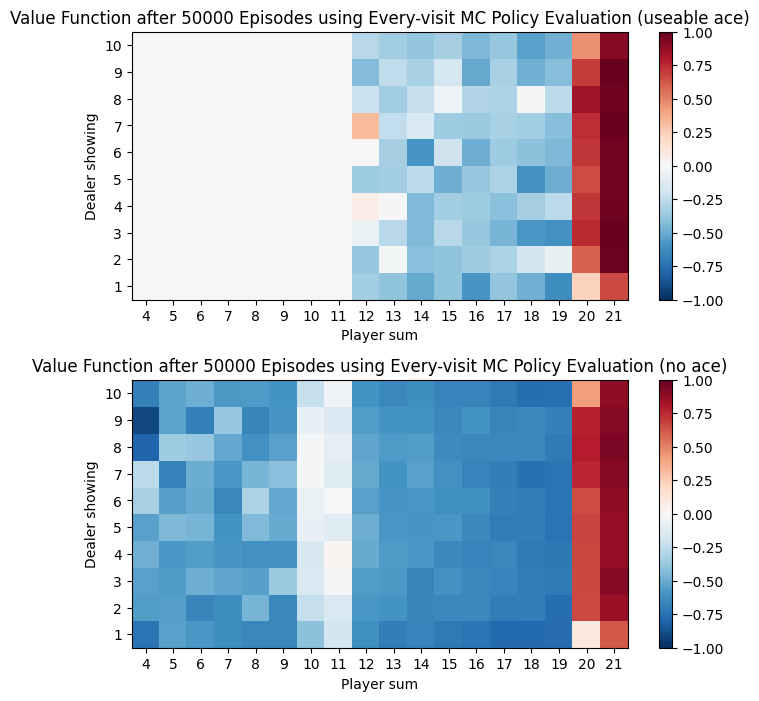

In [37]:
blackjack.plot_value_function(
    ev_policy_value,
    title=f"Value Function after {n_episodes} Episodes using Every-visit MC Policy Evaluation",
)

## (3) Monte Carlo Control (6 Points)
Implement the On-policy every-visit MC control for ε-soft policies algorithm.

In [38]:
def mc_control_epsilon_greedy(
    rng: np.random._generator.Generator,
    env: gym.Env,
    initial_policy: BlackJackPolicy,
    generate_episode_func: EpisodeGenerator,
    n_episodes: int = 100,
    gamma: float = 1.0,
    epsilon: float = 0.1,
    n_print_every: int = 10**4,
    seed: int = 1234,
) -> Tuple[BlackJackPolicy, Dict[BlackJackState, np.ndarray]]:
    """
    On-policy every-visit MC control for ε-soft policies algorithm
    Computes an optimal epsilon-greedy policy.

    Args:
        rng: Random number generator
        env: the gym environment
        initial_policy: the inital policy as a dict with the state as the key,
                        and the values being numpy arrays that store the
                        action selection probabilities
        generate_episode_func: the method for generating episodes.
        n_episodes: number of episodes to sample
        gamma: the discount factor
        epsilon: chance to sample a random action
        n_print_every : Print a message after this many episodes
                rng: random number generator
        seed: seed for the random number generator.

    Returns:
        a tuple (policy, Q)
        opt_policy is a dict in the same format as the initial_policy
        Q is a dict with the state as the key,
        and an np.array as value, which contains the state-action values
    """

    # see the note on datastructures in 'mc_policy_evaluation(...)'!
    G_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    G_count = defaultdict(lambda: np.zeros(env.action_space.n))

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # make a copy of the inital policy (it's bad style to change input parameters)
    policy = {k: v.copy() for k, v in initial_policy.items()}

    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        episode = generate_episode_func(
            rng=rng,
            env=env,
            policy=policy,
            seed=int(seed + i_episode),
        )

        # TODO: compute return G, update G_sum, G_count, and Q
        # YOUR CODE HERE
        # Calculate returns for each step
        G = 0.0
        # Process episode backwards
        G = 0
        visited_state_action_pairs = set()
        
        for t in reversed(range(len(episode))):  
            state, action, reward = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited_state_action_pairs:
                visited_state_action_pairs.add((state, action))  
        
                G_sum[state][action] += G
                G_count[state][action] += 1
                Q[state][action] = G_sum[state][action] / G_count[state][action]

        # TODO: 
                best_action = np.argmax(Q[state])
                for a in range(env.action_space.n):
                    if state not in policy:
                        policy[state] = np.ones(env.action_space.n) / env.action_space.n
                    if a == best_action:
                        policy[state][a] = 1 - epsilon + (epsilon / env.action_space.n)
                    else:
                        policy[state][a] = epsilon / env.action_space.n
    return policy, Q

### Run MC Control for Black Jack
Finally, let's compute a better policy for the Black Jack game. One hint: the results may differ slightly from the lecture slides. They will also be different from the optimal policies in the book, as the ones in the book were computed with 'Exploring Starts'. Do not worry too much about it, but you can always try with a few more samples...

In [39]:
# here, we start from the example policy
n_episodes = 10**4
n_print_every = 10**3

initial_policy = create_example_policy()

# and now run our MC control algorithm
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng,
    blackjack_env,
    initial_policy,
    generate_episode_func=generate_episode,
    n_episodes=n_episodes,
    epsilon=0.1,
    n_print_every=n_print_every,
    seed=1234,
)

assert any(
    [np.all(initial_policy[st] != val) for st, val in opt_policy.items()]
), "Your policy was not changed"
for state, val in opt_Q.items():
    assert testing.is_type(state, tuple)
    assert testing.is_type(state[0], [int, np.int64])
    assert testing.is_type(state[1], [int, np.int64])
    assert testing.is_type(state[2], int)
    assert testing.is_type(val, np.ndarray)

# determine how good our policy is, in terms of v(s)
opt_V = mc_every_visit_policy_evaluation(
    rng,
    blackjack_env,
    opt_policy,
    generate_episode_func=generate_episode,
    n_episodes=n_episodes,
    n_print_every=n_print_every,
    seed=1234,
)



Episode 1000/10000.
Episode 2000/10000.
Episode 3000/10000.
Episode 4000/10000.
Episode 5000/10000.
Episode 6000/10000.
Episode 7000/10000.
Episode 8000/10000.
Episode 9000/10000.
Episode 10000/10000.
Episode 1000/10000.
Episode 2000/10000.
Episode 3000/10000.
Episode 4000/10000.
Episode 5000/10000.
Episode 6000/10000.
Episode 7000/10000.
Episode 8000/10000.
Episode 9000/10000.
Episode 10000/10000.


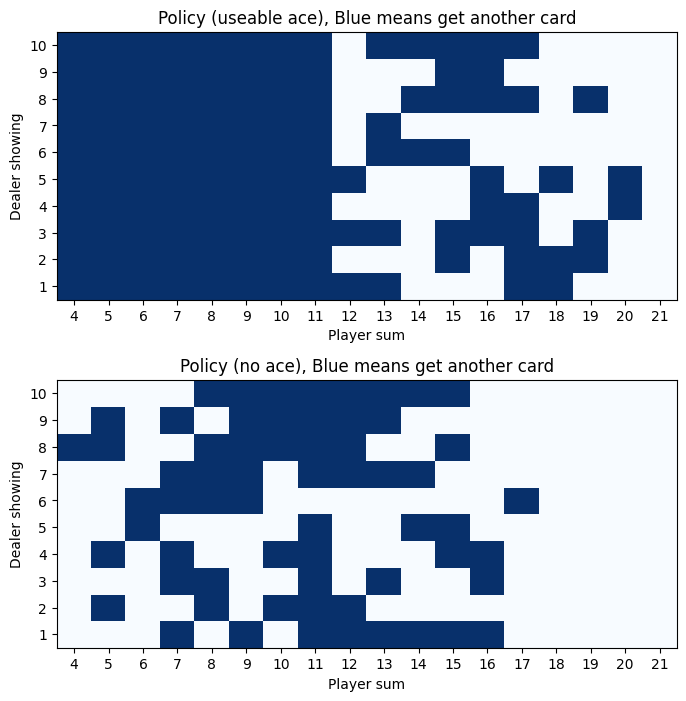

<Figure size 640x480 with 0 Axes>

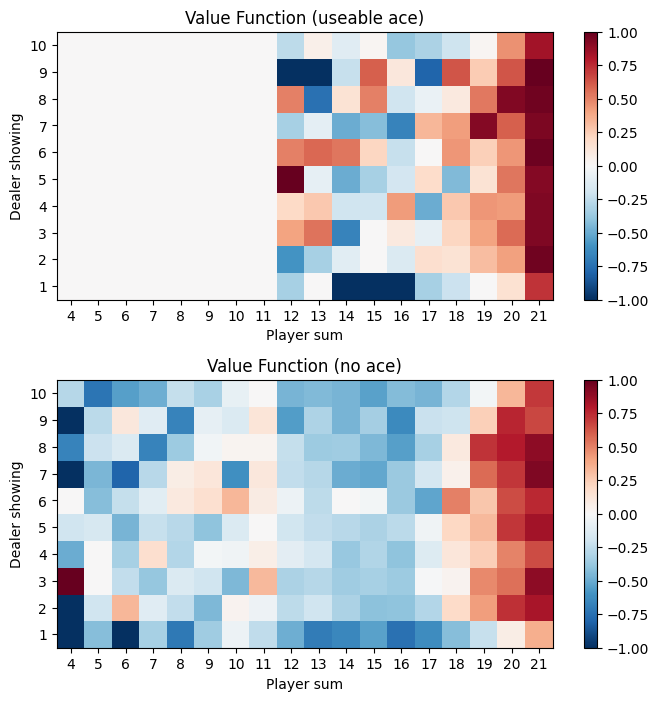

In [40]:
# plot the policy
blackjack.plot_policy(opt_policy)

# and its associated value function
blackjack.plot_value_function(opt_V)

---
# Fishlake Revisited with Monte Carlo methods
We will now go back to the Fishlake and run the MC algorithms on this problem. You will need to answer a textual question, after you tried MC on the Fishlake environment.

In order to run MC, we will need a few convenience functions for converting a value function and policy (a dict in the MC algorithms) to arrays, so we can re-use the existing plotting functions for the Fishlake environment.

In [41]:
def d2a_policy(env, policy):
    policy_array = np.zeros((env.observation_space.n, env.action_space.n))
    for state, ap in policy.items():
        policy_array[state, :] = ap
    return policy_array


def d2a_V(env, V):
    V_array = np.zeros(env.observation_space.n)
    for state, value in V.items():
        V_array[state] = value
    return V_array


def fishlake_random_policy(env):
    policy = defaultdict()
    for state in range(env.observation_space.n):
        policy[state] = np.ones(env.action_space.n) / env.action_space.n
    return policy

## Run MC Evaluation on Fishlake

In [42]:
# we start with the smaller lake
small_lake_env = gym.make("FishlakeStreamy-v0")

# let's create a random policy
random_policy = fishlake_random_policy(small_lake_env)

# and now let's see how good our policy is
rng = np.random.default_rng(4321)
V_dict = mc_every_visit_policy_evaluation(
    rng=rng,
    env=small_lake_env,
    policy=random_policy,
    generate_episode_func=generate_episode,
    n_episodes=200,
    seed=1234,
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.s2rc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s2rc` for environment variables or `env.get_wrapper_attr('s2rc')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.ncol to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can 

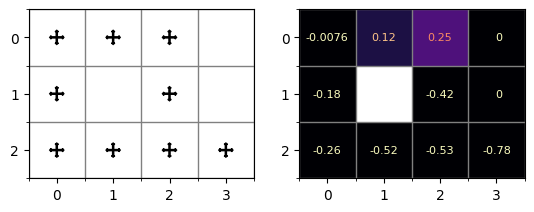

In [43]:
# let's plot this
random_policy_array = d2a_policy(small_lake_env, random_policy)
V_array = d2a_V(small_lake_env, V_dict)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, random_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, V_array)
plt.show()

## Run MC Control on Fishlake

In [44]:
# we start with the smaller lake
small_lake_env = gym.make("FishlakeStreamy-v0")

# let's create a random policy
initial_policy = fishlake_random_policy(small_lake_env)
rng = np.random.default_rng(4321)
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng=rng,
    env=small_lake_env,
    initial_policy=initial_policy,
    generate_episode_func=generate_episode,
    n_episodes=10**4,
    epsilon=0.1,
    seed=1234,
)

# and now let's see how good our policy is
# Running this cell might take a few minutes!!!
opt_V = mc_every_visit_policy_evaluation(
    rng=rng,
    env=small_lake_env,
    policy=opt_policy,
    generate_episode_func=generate_episode,
    n_episodes=10**4,
    seed=1234,
)

Episode 10000/10000.
Episode 10000/10000.


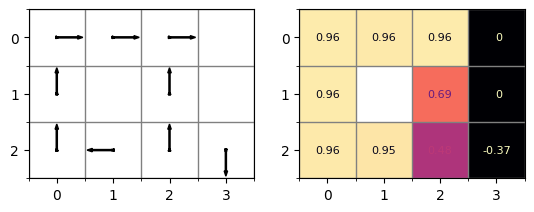

In [45]:
# let's plot this
opt_policy_array = d2a_policy(small_lake_env, opt_policy)
opt_V_array = d2a_V(small_lake_env, opt_V)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, opt_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, opt_V_array)
plt.show()

### (4) Differences DP/MC (2 Point)
Compare the results from MC Evaluation and Control with the results you got via dynamic programming in the last exercise. What could be the reasons for the differences you are seeing?

The differences between MC and DP results on the Fishlake environment stem from their fundamental approaches to learning. While DP uses complete model information including exact transition probabilities and rewards to calculate precise value estimates for all states, MC must learn from sampled experiences and actual trajectories in the environment. This leads to MC showing more variance in its value estimates, particularly in states that are visited less frequently during episodes. The MC policy appears less stable and optimal compared to DP, partly due to epsilon-greedy exploration forcing some random actions and the variance in return estimates from sampling. Additionally, states near the starting position tend to have better estimates in MC since they're sampled more frequently, whereas DP updates all states equally regardless of their accessibility. These differences highlight the tradeoff between model-free methods like MC, which require less prior knowledge but show more variance, and model-based approaches like DP which provide more precise results but need complete environment information.E

### (5) Answer whether the following statements are true or false. (4 Points, 1 point per question)
1. Following the MC policy above, it is possible for the fisherman to catch the fish.
2. If you have a non-episodic task we cannot use Monte Carlo methods
3. All Monte Carlo policy estimation methods are biased
4. After an infinite number of episodes, first-visit and every-visit Monte Carlo policy estimation algorithms converge to different solutions

In [46]:
results = {
    "1": None,
    "2": None,
    "3": None,
    "4": None,
}

# YOUR CODE HERE
results = {
    "1": True,  # Yes, the fisherman can catch the fish - reviewing the policy plot shows paths leading 
                # to the fish states with non-zero probability, even though it may not be the most efficient route
    
    "2": True,  # Monte Carlo methods cannot be used for non-episodic tasks because they require episodes to 
                # terminate to calculate the complete return. Without termination, we cannot work backwards to 
                # compute returns
    
    "3": False, # Monte Carlo methods are actually unbiased estimators of the value function. While individual 
                # sample returns may vary, their average converges to the true expected value
    
    "4": False, # Both first-visit and every-visit Monte Carlo methods converge to the same true value function 
                # in the limit of infinite episodes. They just use different data points (first visits vs all visits) 
                # to arrive at the same result
}

In [47]:
assert testing.is_type(results["1"], bool)

In [48]:
assert testing.is_type(results["2"], bool)

In [49]:
assert testing.is_type(results["3"], bool)

In [50]:
assert testing.is_type(results["4"], bool)